In [67]:
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv("./USvideos.csv")
len(df)

40949

In [69]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [70]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [71]:
df["publish_time"]=pd.to_datetime(df["publish_time"])
df=df.assign(publish_day=df.publish_time.dt.day,publish_month=df.publish_time.dt.month,publish_year=df.publish_time.dt.year)

df["trending_date"]=pd.to_datetime(df["trending_date"], format="%y.%d.%m")
df=df.assign(trending_day=df.trending_date.dt.day,trending_month=df.trending_date.dt.month,trending_year=df.trending_date.dt.year)


In [72]:
df.drop(df[df["publish_year"]<2017].index,inplace=True)
df.drop(df[(df["publish_month"]<11) & (df["publish_month"]>7)].index,inplace=True)

In [73]:
df.drop(["tags","description","title","channel_title","publish_time","video_id","thumbnail_link","trending_date"],axis=1,inplace=True)


In [74]:
df["comments_disabled"]=(df["comments_disabled"]=="True").astype(int)
df["ratings_disabled"]=(df["ratings_disabled"]=="True").astype(int)
df["video_error_or_removed"]=(df["video_error_or_removed"]=="True").astype(int)

In [75]:
#df["likes"]=np.log(df["likes"])
df["dislikes"]=np.log(df["dislikes"])
df["views"]=np.log(df["views"])
df["likes"]=df["likes"].replace([np.inf,-np.inf],np.nan)
df["views"]=df["views"].replace([np.inf,-np.inf],np.nan)
df["dislikes"]=df["dislikes"].replace([np.inf,-np.inf],np.nan)
df["comment_count"]=df["comment_count"].replace([np.inf,-np.inf],np.nan)
df.dropna(axis=0,how='any',inplace=True)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [76]:
df.head(5)

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_day,publish_month,publish_year,trending_day,trending_month,trending_year
0,22,13.525658,57527,7.994970,15954,0,0,0,13,11,2017,14,11,2017
1,24,14.698775,97185,8.723557,12703,0,0,0,13,11,2017,14,11,2017
2,23,14.975981,146033,8.582794,8181,0,0,0,12,11,2017,14,11,2017
3,24,12.745975,10172,6.501290,2146,0,0,0,13,11,2017,14,11,2017
4,24,14.555413,132235,7.595387,17518,0,0,0,12,11,2017,14,11,2017


In [77]:
x = df.copy(deep=True)

x=x.drop("likes",axis=1,inplace=False).values
y=df["likes"].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)


In [78]:
df

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_day,publish_month,publish_year,trending_day,trending_month,trending_year
0,22,13.525658,57527,7.994970,15954,0,0,0,13,11,2017,14,11,2017
1,24,14.698775,97185,8.723557,12703,0,0,0,13,11,2017,14,11,2017
2,23,14.975981,146033,8.582794,8181,0,0,0,12,11,2017,14,11,2017
3,24,12.745975,10172,6.501290,2146,0,0,0,13,11,2017,14,11,2017
4,24,14.555413,132235,7.595387,17518,0,0,0,12,11,2017,14,11,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,15,14.337637,38160,7.233455,2657,0,0,0,18,5,2018,14,6,2018
40945,22,13.878296,60008,5.945421,3936,0,0,0,18,5,2018,14,6,2018
40946,24,13.879847,48068,6.939254,3992,0,0,0,18,5,2018,14,6,2018
40947,1,15.549078,192957,7.953670,13088,0,0,0,17,5,2018,14,6,2018


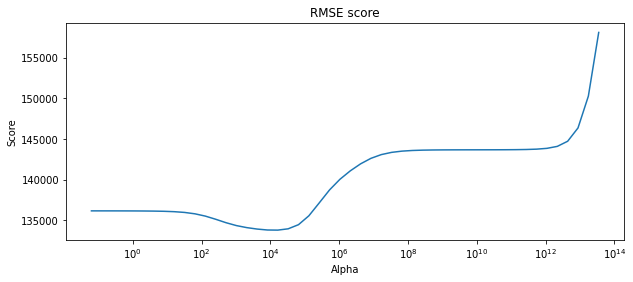

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,4))

ax.set_title('RMSE score')
ax.set_xscale("log")
ax.set_xlabel('Alpha')
ax.set_ylabel('Score')

n = 50
cnt = np.zeros(n)
xx = np.ndarray((n), dtype=float)
val = np.ndarray((n), dtype=float)
for i in range(n):
    xx[i] = 2**(i-4)
    val[i] = (cross_val_score(Ridge(alpha=xx[i]), x, y, scoring='neg_root_mean_squared_error') * -1).mean()

ax.plot(xx, val)
plt.show()

In [80]:
y_pred_linreg = Ridge(alpha=10**4).fit(x_train, y_train).predict(x_test)
from sklearn.metrics import mean_squared_error
print('Linreg RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_linreg)))

Linreg RMSE: 116737.20510919881


In [81]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier(n_estimators = 3, warm_start=True).fit(x_train[0:10000], y_train[0:10000])
y_pred_trees=clf.predict(x_test)

print('Trees RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_trees)))

Trees RMSE: 135346.1439204266
